In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
import pickle
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

from src.data.data_fetcher import get_all_features, get_raw_data
from src.features.feature_engineering import prepare_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)


from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')




In [2]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined, X_train_est_combined, X_val_est_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined, y_train_est_combined, y_val_est_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)


x_whole.head(10)

After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 48), X_test_estimated_b_processed.shape = (720, 48), X_test_estimated_c_processed.shape = (720, 48)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,direct_rad_cloud_interaction,modified_solar_elevation_squared,is_freezing,is_snow,is_rain
0,15.200,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.531250,271.225006,8.723576e+05,54.224998,1.0,0.00,0.0000,0.00,1007.500000,0.000,0.0,72.375000,92.172501,0.000,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.455669,0.645392,0,0.548142,1,366.725006,12415.325195,0.675033,0,0,0
1,13.700,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.687500,5.800000,1.174988e+04,99.675003,1.0,0.00,0.0000,0.00,1001.400024,0.000,0.1,80.699997,236.257751,0.100,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.611489,0.004784,0,0.996750,1,151.325012,1.884982,0.781978,0,0,0
2,10.500,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.656250,65.099998,1.359929e+05,23.299999,1.0,0.00,0.0000,0.00,1006.849976,0.000,0.0,59.049999,85.390503,0.000,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.164161,0.626034,0,0.535017,0,107.300003,4993.169922,0.405168,0,0,0
3,6.300,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.000000,0.000000,0.000000e+00,99.574997,0.0,1.00,0.0000,0.00,992.949951,0.000,0.0,93.650002,127.701752,0.350,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.000000,0,0.995999,1,0.000000,0.000000,0.000000,0,0,0
4,6.300,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.000000,0.000000,0.000000e+00,49.400002,0.0,1.00,0.0000,0.00,1012.200012,0.000,0.0,81.649994,346.724243,0.000,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.000000,0,0.499874,1,0.000000,0.000000,0.000000,0,0,0
5,4.025,1.28000,1.452865e+04,14.250000,844.275024,0.0,270.700012,8.875000,15948.400391,4.425000,7.955200e+03,9.575000,1.0,0.75,0.0000,0.00,994.125000,0.000,0.0,90.824997,135.347992,0.000,273.625000,9.575000,37888.300781,2.300,1.250,1.925,0.0,0,1,0,0.537677,0.843151,0.866025,-5.000000e-01,39.271877,0.032549,0.547553,0,1.000000,0,13.300000,400.130646,0.180413,0,0,0
6,5.550,1.27250,0.000000e+00,0.000000,3068.200195,0.0,275.274994,0.000000,0.000000,0.000000,0.000000e+00,58.000000,0.0,1.00,0.0000,0.00,1017.000000,0.000,0.0,50.400002,331.056000,0.000,283.750000,98.875000,33853.199219,0.750,-0.200,0.725,0.0,0,1,0,0.968251,-0.249981,-0.707107,7.071068e-01,0.000000,0.000000,0.000000,0,0.586599,1,0.000000,0.000000,0.000000,0,0,0
7,4.325,1.28750,0.000000e+00,0.000000,0.000000,-0.5,271.700012,0.000000,0.000000,0.000000,0.000000e+00,4.775000,0.0,1.00,0.0000,0.00,1009.450012,1.875,0.0,64.400002,44.770248,0.000,279.549988,8.950000,34397.699219,1.600,0.125,1.600,0.0,0,0,1,0.954067,-0.299595,0.500000,8.660254e-01,0.000000,0.000000,0.000000,0,0.533520,0,0.000000,0.000000,0.000000,0,0,0
8,7.225,1.24150,0.000000e+00,0.000000,1859.074951,0.0,279.250000,0.000000,0.000000,0.000000,0.000000e+00,99.900002,0.0,1.00,0.0175,0.75,1002.549988,0.000,0.0,77.925003,284.348236,0.075,282.600006,100.000000,33559.425781,1.650,-

In [4]:
x_whole["time_since_prediction"].describe()

count    87876.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: time_since_prediction, dtype: float64

In [ ]:
x_whole["pv_measurement"] = y_whole
df_shuffled = x_whole.sample(frac=1, random_state=42).reset_index(drop=True)
x_whole_a = df_shuffled[df_shuffled['location_a'] == 1]
x_whole_b = df_shuffled[df_shuffled['location_b'] == 1]
x_whole_c = df_shuffled[df_shuffled['location_c'] == 1]

y_whole_a = x_whole_a["pv_measurement"]
x_whole_a = x_whole_a.drop("pv_measurement", axis = 1)
x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

y_whole_b = x_whole_b["pv_measurement"]
x_whole_b = x_whole_b.drop("pv_measurement", axis = 1)
x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

y_whole_c = x_whole_c["pv_measurement"]
x_whole_c = x_whole_c.drop("pv_measurement", axis = 1)
x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)

In [ ]:
reg_a = CatBoostRegressor(
        iterations=1000,
        max_depth=9,
        loss_function='MAE',
        verbose=200
    )


    # Fit the model using the sample weights
reg_a.fit(x_whole_a, y_whole_a)


0:	learn: 615.6538239	total: 177ms	remaining: 2m 57s
200:	learn: 184.4832078	total: 6.95s	remaining: 27.6s
400:	learn: 175.1196078	total: 13.6s	remaining: 20.3s
600:	learn: 162.3915598	total: 20.3s	remaining: 13.4s
800:	learn: 144.2267520	total: 26.8s	remaining: 6.65s
999:	learn: 134.0667558	total: 33.3s	remaining: 0us


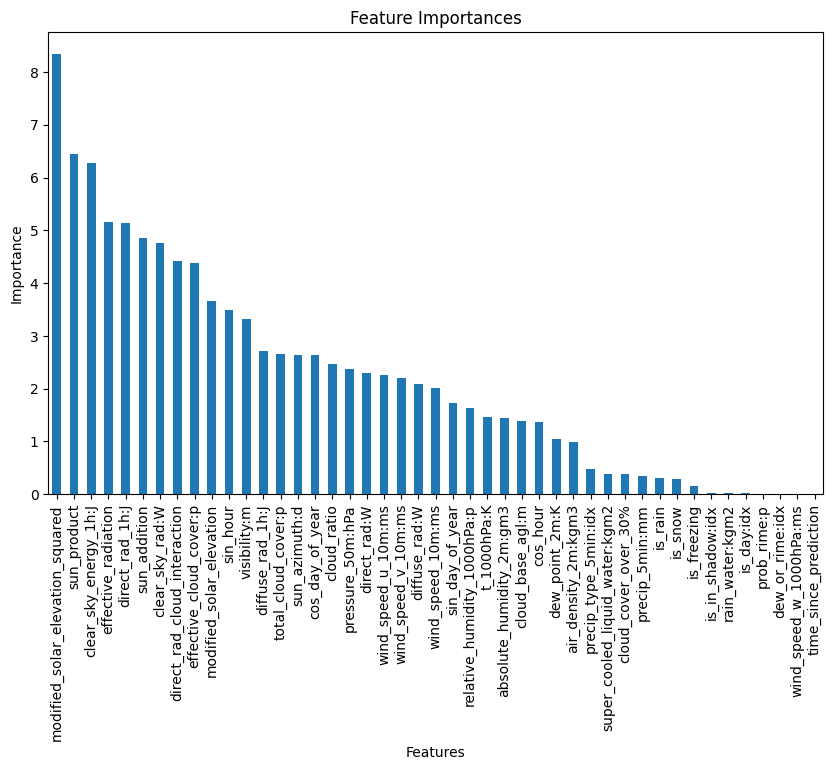

In [ ]:
feature_importances = reg_a.get_feature_importance()

# Assuming you have a pandas DataFrame for your features
feature_names = x_whole_a.columns

# Create a pandas Series to view the feature importances neatly
importance_series = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance
sorted_importance = importance_series.sort_values(ascending=False)

# Visualize the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_importance.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [ ]:
reg_b = CatBoostRegressor(
        iterations=1000,
        max_depth=9,
        loss_function='MAE',
        verbose=200
    )


    # Fit the model using the sample weights
reg_b.fit(x_whole_b, y_whole_b)


0:	learn: 94.6681169	total: 33.7ms	remaining: 33.7s
200:	learn: 22.0042965	total: 6.47s	remaining: 25.7s
400:	learn: 19.3228397	total: 12.7s	remaining: 19s
600:	learn: 17.4863166	total: 18.9s	remaining: 12.5s
800:	learn: 15.9400379	total: 25.1s	remaining: 6.24s
999:	learn: 15.0355711	total: 31.1s	remaining: 0us


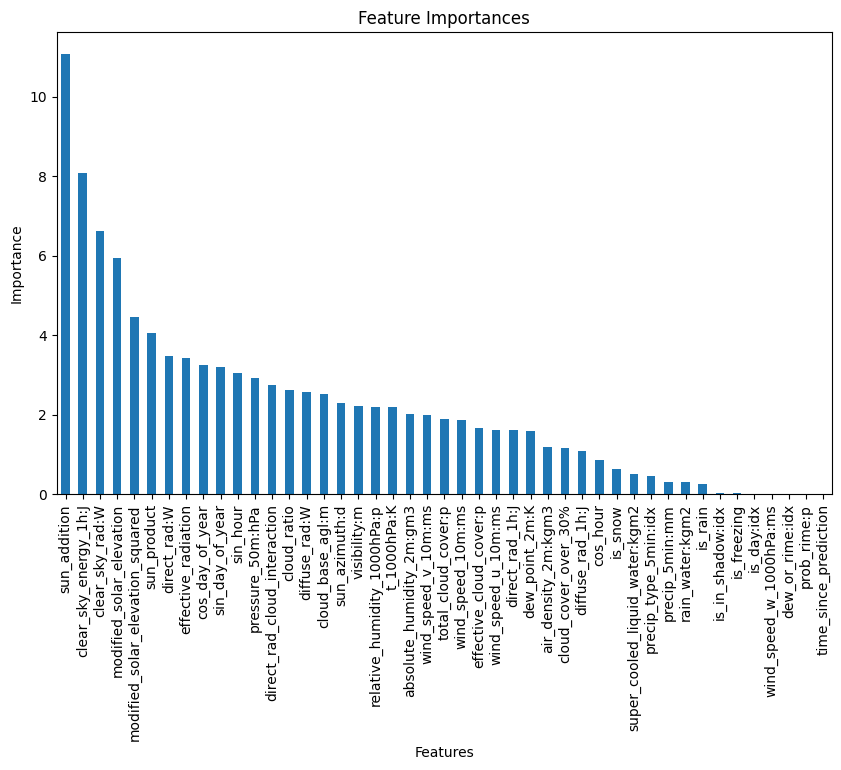

In [ ]:
feature_importances = reg_b.get_feature_importance()

# Assuming you have a pandas DataFrame for your features
feature_names = x_whole_b.columns

# Create a pandas Series to view the feature importances neatly
importance_series = pd.Series(feature_importances, index=feature_names)

# Sort the features by importance
sorted_importance = importance_series.sort_values(ascending=False)

# Visualize the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sorted_importance.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()

In [ ]:
x_whole_b["time_since_prediction"].describe()

count    28688.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: time_since_prediction, dtype: float64

In [ ]:
reg_c = CatBoostRegressor(
        iterations=1000,
        max_depth=9,
        loss_function='MAE',
        verbose=200
    )


    # Fit the model using the sample weights
reg_c.fit(x_whole_c, y_whole_c)


0:	learn: 78.5030665	total: 51.4ms	remaining: 51.4s
200:	learn: 18.5930804	total: 6.47s	remaining: 25.7s
400:	learn: 16.0605810	total: 12.7s	remaining: 18.9s
600:	learn: 13.8274611	total: 18.8s	remaining: 12.5s
800:	learn: 12.9376728	total: 25s	remaining: 6.21s
999:	learn: 12.2729550	total: 31s	remaining: 0us


In [ ]:
x_whole_a = x_test_whole[x_test_whole['location_a'] == 1]
x_whole_b = x_test_whole[x_test_whole['location_b'] == 1]
x_whole_c = x_test_whole[x_test_whole['location_c'] == 1]

x_whole_a = x_whole_a.drop('location_a', axis = 1)
x_whole_a = x_whole_a.drop('location_b', axis = 1)
x_whole_a = x_whole_a.drop('location_c', axis = 1)

x_whole_b = x_whole_b.drop('location_a', axis = 1)
x_whole_b = x_whole_b.drop('location_b', axis = 1)
x_whole_b = x_whole_b.drop('location_c', axis = 1)

x_whole_c = x_whole_c.drop('location_a', axis = 1)
x_whole_c = x_whole_c.drop('location_b', axis = 1)
x_whole_c = x_whole_c.drop('location_c', axis = 1)

In [ ]:
y_pred_a = reg_a.predict(x_whole_a)
y_pred_b = reg_b.predict(x_whole_b)
y_pred_c = reg_c.predict(x_whole_c)
y_pred = pd.concat([pd.Series(y_pred_a), pd.Series(y_pred_b), pd.Series(y_pred_c)])
y_pred = y_pred.reset_index(drop=True)
# Save the model
from src.models.saving import save_predictions
from src.features.postprocess_data import postprocess_data

y_pred = postprocess_data(x_test_whole, pd.DataFrame(y_pred))
save_predictions(y_pred, 'catboost logcosh')

hour: 0, min_value_a: 0.0, max_value_a: 3.3, min_value_b: -0.0, max_value_b: -0.0, min_value_c: 0.0, max_value_c: 0.0
hour: 1, min_value_a: 0.0, max_value_a: 53.68, min_value_b: -0.0, max_value_b: 12.075, min_value_c: 0.0, max_value_c: 9.8
hour: 2, min_value_a: 0.0, max_value_a: 233.64000000000001, min_value_b: -0.0, max_value_b: 68.1375, min_value_c: 0.0, max_value_c: 39.2
hour: 3, min_value_a: 0.0, max_value_a: 439.12, min_value_b: -0.0, max_value_b: 138.0, min_value_c: 0.0, max_value_c: 88.2
hour: 4, min_value_a: 0.0, max_value_a: 1046.98, min_value_b: -0.0, max_value_b: 307.05, min_value_c: 0.0, max_value_c: 176.4
hour: 5, min_value_a: 0.0, max_value_a: 2049.08, min_value_b: -0.0, max_value_b: 452.8125, min_value_c: 0.0, max_value_c: 264.6
hour: 6, min_value_a: 0.0, max_value_a: 3244.78, min_value_b: -0.0, max_value_b: 681.375, min_value_c: 0.0, max_value_c: 499.8
hour: 7, min_value_a: 0.0, max_value_a: 4266.46, min_value_b: -0.0, max_value_b: 865.0875, min_value_c: 0.0, max_value_